# Clustering analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the second task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in clustering analysis.

Clustering analysis is a powerful data exploration technique that aims to group similar data points together based on certain features or characteristics. It plays a crucial role in uncovering underlying patterns and structures within large datasets, allowing for the identification of distinct subsets or clusters. In this analysis, we employ clustering algorithms to discern natural groupings within our datasets, providing valuable insights into the inherent relationships among data points. This method enhances our understanding of complex datasets by revealing patterns that may not be immediately apparent, thereby facilitating more targeted and informed decision-making processes.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [1]:
%%capture
!python -m pip install --upgrade pip
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install kneed

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

After importing the required libraries, we will read the datasets that we have exported in the task 1, which they contain the data filtered after the data preparation tasks.

In [3]:
# Load the three datasets
incidents_dataset = pd.read_csv('../project_datasets/incidents_v2.csv', low_memory=False)
pbsy_dataset = pd.read_csv('../project_datasets/povertyByStateYear_v2.csv')
ysdh_dataset = pd.read_csv('../project_datasets/year_state_district_house_v2.csv')

## Clustering Analysis by K-means on the entire dataset

First clustering approach that we will use will be the clustering analysis by K-means.

### Identification of the best k value

To start, we perform K-means clustering on the `incidents_dataset` after dropping rows with missing values and selecting numeric features for clustering. The selected features are standardized using `StandardScaler`, and the optimal number of clusters (`k`) is determined using `KneeLocator` from `kneed` library, which employs the Elbow Method to do it. In this case, we get that the optimal `k` value is 3. After calculating it, a plot is generated to visualize the "elbow" point, aiding in the identification of the optimal number of clusters.

Optimal k value: 3


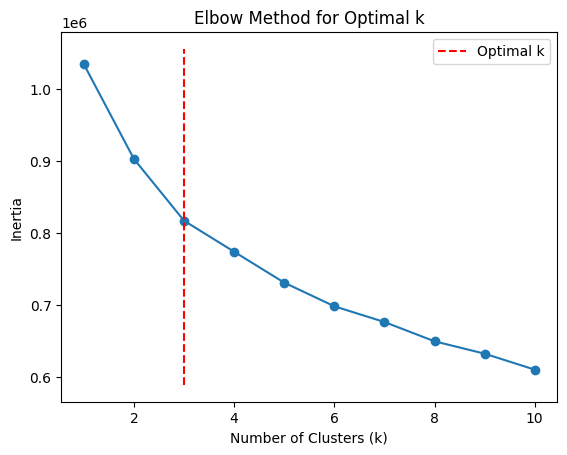

In [4]:
# Drop rows with missing values
data_for_clustering = incidents_dataset.dropna()

# Select all features for clustering
selected_features = data_for_clustering.columns

# Exclude non-numeric columns (e.g., 'object' type columns)
selected_features = data_for_clustering.select_dtypes(include=['number']).columns

# Standardize features
scaler = StandardScaler()
data_for_clustering_standardized = scaler.fit_transform(data_for_clustering[selected_features])

# Determine the optimal number of clusters (k) using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Explicitly set n_init
    kmeans.fit(data_for_clustering_standardized)
    inertia.append(kmeans.inertia_)

# Find the optimal k using the KneeLocator from kneed library
knee = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
optimal_k = knee.elbow

# Print the optimal k
print(f"Optimal k value: {optimal_k}")

# Plot the elbow method with the optimal k
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Optimal k')
plt.legend()
plt.show()


### Cluster generation and comparison

After identifying the best *k* value for clustering, we start performing *k-means* clustering on the standardized data.

The algorithm assigns each data point to a cluster and adds the cluster labels as a new column (`cluster`) to the original dataset. After clustering, we calculate the centroids of each cluster and transforms them back to the original scale using the scaler. The resulting centroids are then printed, providing insights into the representative values of the features for each cluster.

These centroids represent the average values of various features within each cluster resulting from the k-means clustering. Each row corresponds to one cluster, and the columns display the centroids of different features. For instance, in the 'latitude' and 'longitude' columns, the values represent the average geographic coordinates of incidents within each cluster. Similarly, the 'participant_age1' column shows the average age of participants in each cluster. The 'cluster' column indicates the assigned cluster label for each row, and therefore, the presence of three rows indicates that there are three clusters (0, 1, and 2). 

In [5]:
# Perform k-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)  # Explicitly set n_init
clusters_kmeans = kmeans.fit_predict(data_for_clustering_standardized)

# Add clusters to the original dataset
incidents_dataset['cluster'] = pd.Series(clusters_kmeans, index=data_for_clustering.index)

# Analysis of k centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=selected_features)
print("Centroids:")
print(centroids)

Centroids:
    latitude  longitude  congressional_district  state_house_district  \
0  37.389236 -90.196039                8.660199             56.375041   
1  38.208466 -88.435187                7.916108             54.402553   
2  37.310108 -88.438568                8.225603             57.586428   

   state_senate_district  participant_age1  min_age_participants  \
0              20.717910         50.056633             46.074627   
1              19.941097         24.193480             23.425993   
2              19.754879         26.373436             21.189170   

   avg_age_participants  max_age_participants  n_participants_child  \
0             48.911360             51.829934              0.001327   
1             24.318594             25.219345              0.040784   
2             25.511861             30.711240              0.085877   

   n_participants_teen  n_participants_adult   n_males  n_females  n_killed  \
0             0.010282              1.612272  1.336816   0.

After getting the centroids and the clusters, we perform a comparison of variable distributions within each cluster. For each cluster (identified by the cluster label), we print descriptive statistics: mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum. Then we create histograms for the three clusters, to visualize the distribution of each variable within the specific cluster.


Cluster 0 Statistics:
                          count         mean        std        min  \
latitude                12068.0    37.391259   5.211555    19.4475   
longitude               12068.0   -90.196555  14.542657  -159.4120   
congressional_district  12068.0     8.658187   8.696045     0.0000   
state_house_district    12068.0    56.360623  44.950830     1.0000   
state_senate_district   12068.0    20.710060  14.366616     1.0000   
participant_age1        12068.0    50.048807  11.547382    17.0000   
min_age_participants    12068.0    46.066954  12.490321     5.0000   
avg_age_participants    12068.0    48.902967  10.456710    28.0000   
max_age_participants    12068.0    51.820931  11.363408    33.0000   
n_participants_child    12068.0     0.001326   0.044577     0.0000   
n_participants_teen     12068.0     0.010275   0.111018     0.0000   
n_participants_adult    12068.0     1.612280   0.710810     1.0000   
n_males                 12068.0     1.336758   0.691099     0.0000 

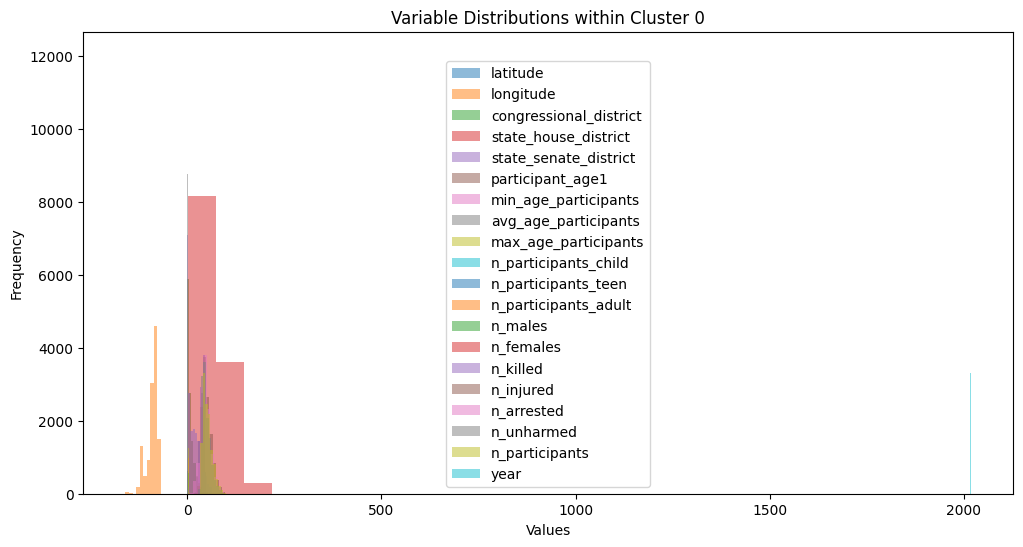


Cluster 1 Statistics:
                          count         mean        std        min  \
latitude                29695.0    38.207476   4.894472    19.4331   
longitude               29695.0   -88.434863  12.856962  -159.3590   
congressional_district  29695.0     7.917629   7.698257     0.0000   
state_house_district    29695.0    54.410978  44.389755     1.0000   
state_senate_district   29695.0    19.946893  14.622774     1.0000   
participant_age1        29695.0    24.186732   7.085369     1.0000   
min_age_participants    29695.0    23.419801   6.781761     0.0000   
avg_age_participants    29695.0    24.313420   6.640632     1.0000   
max_age_participants    29695.0    25.215053   7.426456     1.0000   
n_participants_child    29695.0     0.040916   0.220313     0.0000   
n_participants_teen     29695.0     0.170163   0.452914     0.0000   
n_participants_adult    29695.0     1.195386   0.626699     0.0000   
n_males                 29695.0     1.289712   0.558331     0.0000 

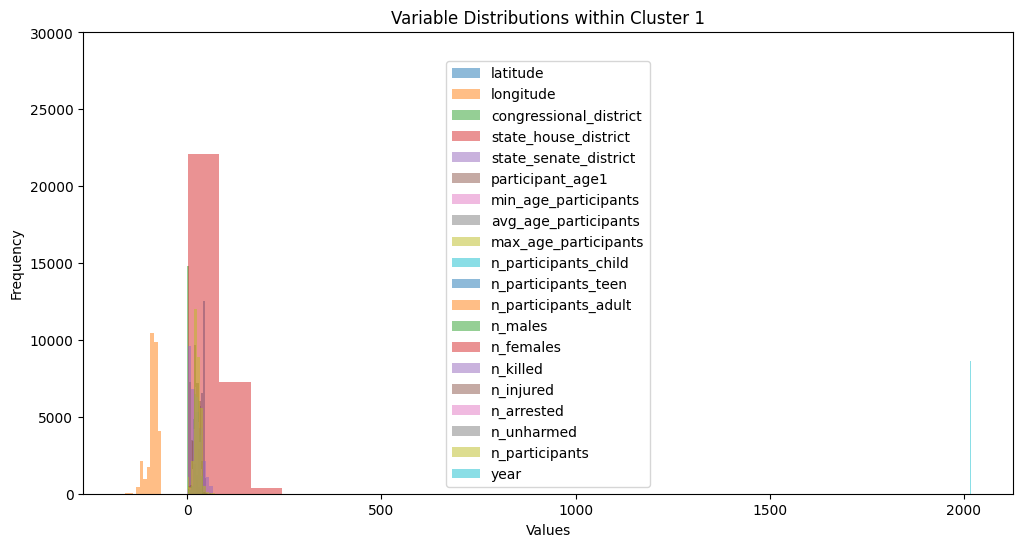


Cluster 2 Statistics:
                         count         mean        std        min        25%  \
latitude                9981.0    37.310364   5.106094    19.4664    33.5913   
longitude               9981.0   -88.437503  12.877026  -158.0700   -90.3205   
congressional_district  9981.0     8.223224   8.010643     0.0000     2.0000   
state_house_district    9981.0    57.580403  43.038861     1.0000    22.0000   
state_senate_district   9981.0    19.746318  14.041520     1.0000     8.0000   
participant_age1        9981.0    26.384430  10.355959     1.0000    20.0000   
min_age_participants    9981.0    21.196473   7.035650     0.0000    17.0000   
avg_age_participants    9981.0    25.518886   7.109167     1.0000    20.0000   
max_age_participants    9981.0    30.719066  11.354377     1.0000    22.0000   
n_participants_child    9981.0     0.085563   0.395482     0.0000     0.0000   
n_participants_teen     9981.0     0.379421   0.903463     0.0000     0.0000   
n_participants_ad

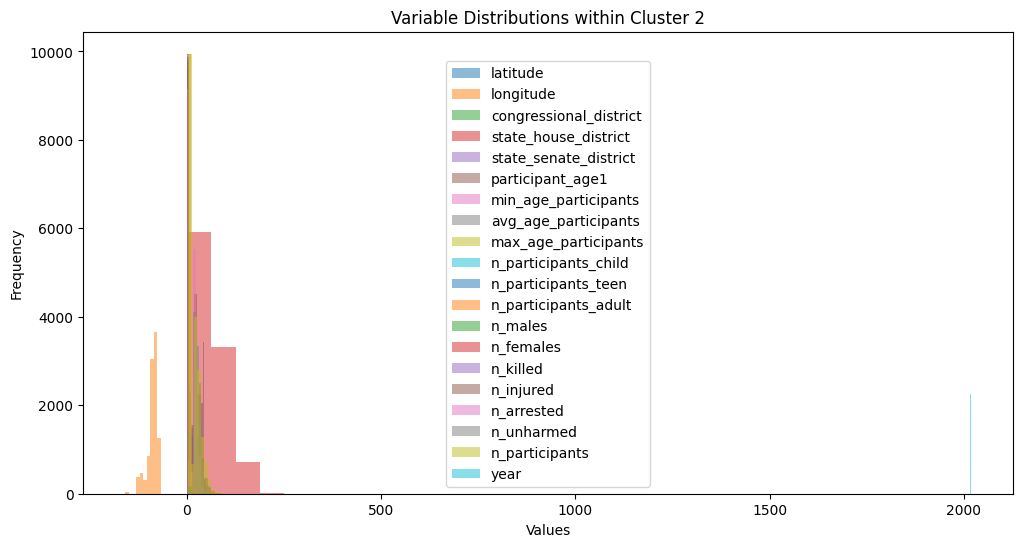

In [6]:
# Comparison of variable distributions within clusters
for cluster_label in range(optimal_k):
    print(f"\nCluster {cluster_label} Statistics:")
    cluster_data = incidents_dataset[incidents_dataset['cluster'] == cluster_label][selected_features]
    cluster_stats = cluster_data.describe().transpose()
    print(cluster_stats)

    # Plot variable distributions within the cluster
    plt.figure(figsize=(12, 6))
    for column in selected_features:
        plt.hist(cluster_data[column], alpha=0.5, label=column)
    plt.title(f"Variable Distributions within Cluster {cluster_label}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

### Cluster evaluation

Now we will evaluate the obtained three cluster in order to define which is the best. To achieve that we will use two different techniques:

- **Silhouette Score**: This approach measures how well-separated the clusters are. A value close to 1 indicates well-defined, distinct clusters, while a score near 0 suggests overlapping clusters. In out case, a score of 0.213 is reasonable. It indicates moderate separation between clusters. However, the clusters may not be perfectly well-defined.
- **Inertia**: It measures the compactness of clusters. It is the sum of squared distances between data points and their assigned cluster center. Lower inertia values indicate more compact clusters. Our inertia value is relatively high, suggesting that the clusters are not very compact. This might indicate that the clusters are spread out or not as tightly grouped as they could be.

Interpreting these metrics together, we can consider that the Silhouette Score suggests moderate separation between clusters, but not highly distinct, while the relatively high Inertia value indicates that the clusters are not very compact. In summary, while the clustering is providing some separation, there is room for improvement, so it could be interesting to test other clustering techniques.

In [7]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(data_for_clustering_standardized, clusters_kmeans)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Inertia
print(f"Inertia: {kmeans.inertia_}")


Silhouette Score: 0.16025499669156135
Inertia: 817536.6037626411


## Analysis by density-based clustering

To test another clustering approach, we will do a analysis by density-based clustering. In this case, we will not use the entire dataset, but a filtered dataset by state. For our test, we will use California as the testing state.

In [8]:
# Filter data for the state of California
california_data = incidents_dataset[incidents_dataset['state'] == 'CALIFORNIA'].copy()

# Drop rows with missing values
california_data = california_data.dropna()

# Select features for clustering
selected_features = california_data.select_dtypes(include=['number']).columns

### Study of the clustering parameters

After having defined the dataset with a unique state, we start with the density-based clustering analysis using DBSCAN. We first standardize the selected features of the dataset for the state of California using `StandardScaler`. Then, we calculate the distance to the k<sup>th</sup> nearest neighbor for each data point and visualize the resulting k-distance graph. The code utilizes the `KneeLocator` algorithm to identify the optimal epsilon (neighborhood distance) by finding the knee point in the graph. In our case, he optimal epsilon value is around 5'2. In the final step we plot the k-distance graph with the identified optimal epsilon marked in red. This process helps determine a suitable parameter for the DBSCAN algorithm when clustering the data.

Optimal Epsilon: 5.209942790875559


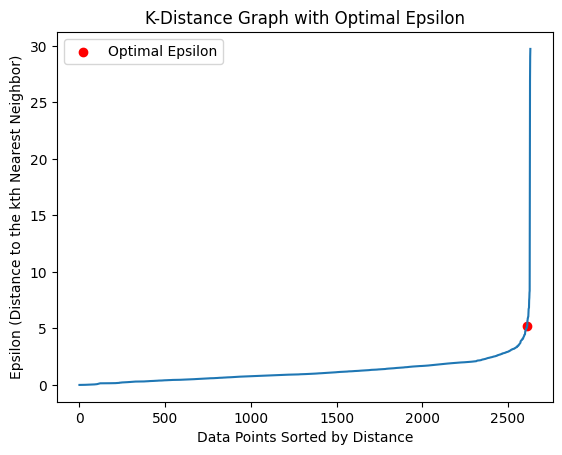

In [9]:
# Standardize features
scaler = StandardScaler()
california_data_standardized = scaler.fit_transform(california_data[selected_features])

# Determine the optimal eps (neighborhood distance) using k-distance graph
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(california_data_standardized)
distances, indices = nbrs.kneighbors(california_data_standardized)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Find the optimal epsilon using the KneeLocator
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
optimal_eps_index = kneedle.knee
optimal_eps = distances[optimal_eps_index]

# Print the optimal epsilon
print(f"Optimal Epsilon: {optimal_eps}")

# Plot the k-distance graph with the identified knee point
plt.plot(distances)
plt.scatter(optimal_eps_index, optimal_eps, c='red', label='Optimal Epsilon')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('Epsilon (Distance to the kth Nearest Neighbor)')
plt.title('K-Distance Graph with Optimal Epsilon')
plt.legend()
plt.show()

### Characterization and interpretation of the obtained clusters

With the optimal epsilon value deined, we perform the Density-Based Spatial Clustering of Applications with Noise (DBSCAN). The DBSCAN algorithm classifies data points into clusters based on their density within defined neighborhoods. The `min_samples` parameter specifies the minimum number of data points required to form a dense region. The resulting clusters are visualized in a scatter plot, where each point represents an incident. The plot uses `avg_age_participants` and `n_participants` as axes, and different colors represent distinct clusters identified by DBSCAN.

From the results obtained, we can see that the clustering creates two clusters, which, looking at the results, we can affirm that they are differentiated between the main trend and the less frequent cases. That is, the yellow dots in the graph represent the most common incidents, which are those with the lowest number of participants. On the contrary, the incidents with the highest number of participants are included in the second cluster, represented by the purple dots.

Number of Clusters: 2


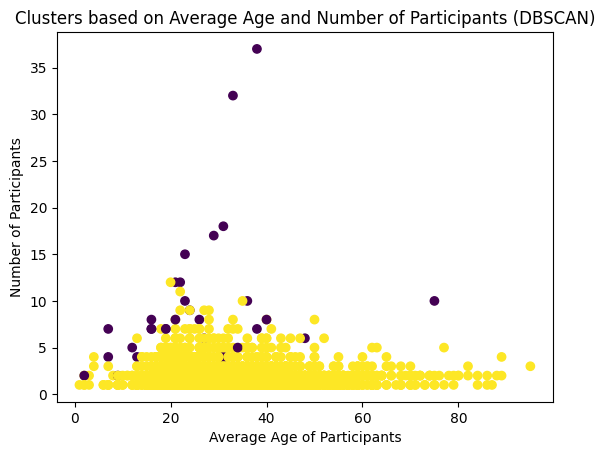

In [10]:
# Perform DBSCAN clustering with the optimal epsilon
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
clusters_dbscan = dbscan.fit_predict(california_data_standardized)

# Add clusters to the original dataset
california_data['cluster'] = pd.Series(clusters_dbscan, index=california_data.index)

num_clusters = california_data['cluster'].nunique()
print(f"Number of Clusters: {num_clusters}")

# Visualize the clusters (replace 'avg_age_participants' and 'n_killed' with actual column names)
plt.scatter(california_data['avg_age_participants'], california_data['n_participants'], c=california_data['cluster'], cmap='viridis')
plt.xlabel('Average Age of Participants')
plt.ylabel('Number of Participants')
plt.title('Clusters based on Average Age and Number of Participants (DBSCAN)')
plt.show()


## Analysis by hierarchical clustering

To conclude with the clustering analysis, we implement an analysis by hierarchical clustering.

As we did in the previous case, we used California as testing state, with a downsampled subset of the incidents dataset in order to visualize the results in a clearer way.

The code iterates through the most used linkage methods:
- **Single Linkage**: Measures the shortest distance between points in two clusters. Sensitive to outliers and tends to form elongated clusters.
- **Complete Linkage**: Measures the longest distance between points in two clusters. Tends to produce more compact, spherical clusters.
- **Average Linkage**: Uses the average distance between points in two clusters. Balanced approach, less sensitive to outliers.
- **Ward Linkage**: Minimizes the variance within clusters. Tends to create equally-sized, compact clusters.

Then for each linkage method we visualize the dendrogram and determines the number of clusters formed. Additionally, we calculate the Silhouette Score for each clustering result. This metric measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher Silhouette Scores indicate better-defined clusters.

Obtained results regarding the number of clusters generated and the Silhouette Score, have been these:

<center>

| Linkage Method | Number of Clusters | Silhouette Score |
|:--------------:|:------------------:|:----------------:|
| Single         | 7                  | 0.314            |
| Complete       | 28                 | 0.164            |
| Average        | 19                 | 0.186            |
| Ward           | 34                 | 0.155            |

</center>

The number of clusters varies across methods, with Complete and Ward Linkage resulting in higher numbers (28 and 34, respectively) compared to Single and Average Linkage. If the goal is to have a more granular segmentation, Complete or Ward Linkage might be preferred.

The Silhouette score provides a measure of how well-defined the clusters are. In this case, Single Linkage has the highest silhouette score (0.314), suggesting that it produces more distinct clusters.

With respect to the cluster structure, different linkage methods lead to variations in cluster shapes and sizes. Single Linkage tends to create elongated clusters, while Complete and Ward Linkage aim for more compact clusters. Average Linkage represents a compromise between these extremes.

In conclusion, if the goal is to prioritize well-defined, compact clusters, Ward Linkage might be considered the best in this context. However, it's essential to consider the trade-offs between granularity and interpretability when choosing the appropriate hierarchical clustering approach.


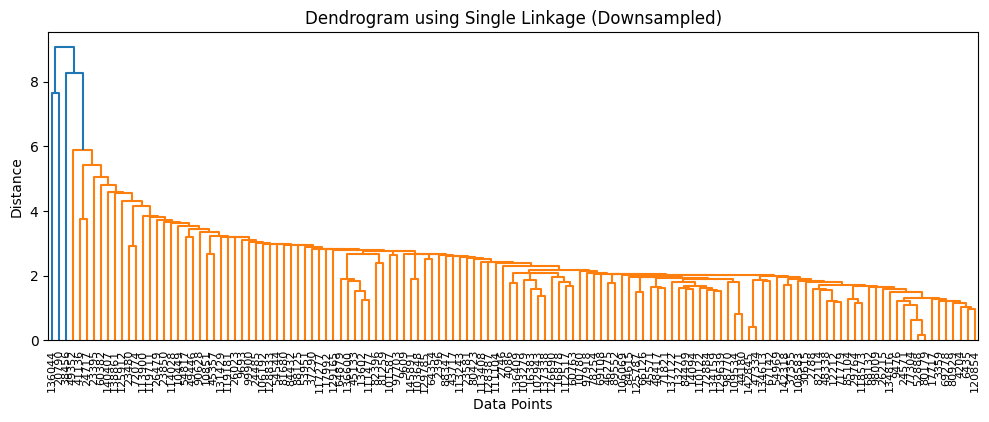

Number of Clusters using Single Linkage (Downsampled): 7
Silhouette Score using Single Linkage (Downsampled): 0.314


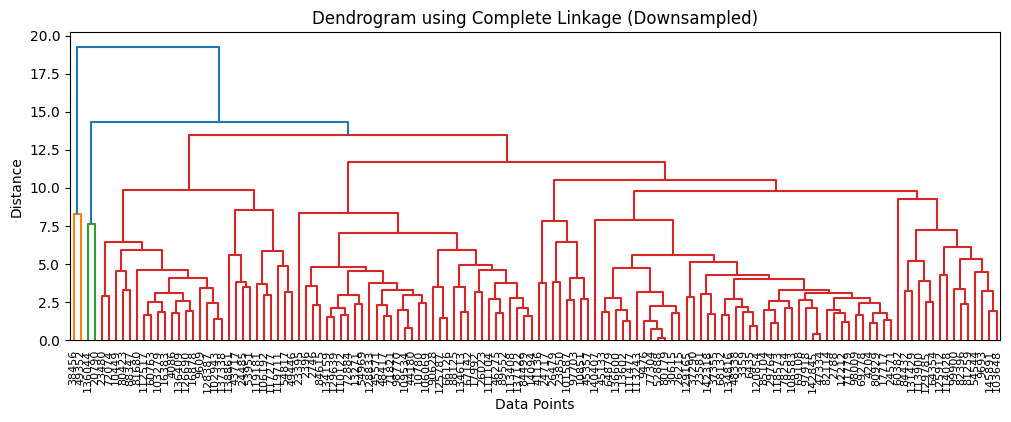

Number of Clusters using Complete Linkage (Downsampled): 28
Silhouette Score using Complete Linkage (Downsampled): 0.164


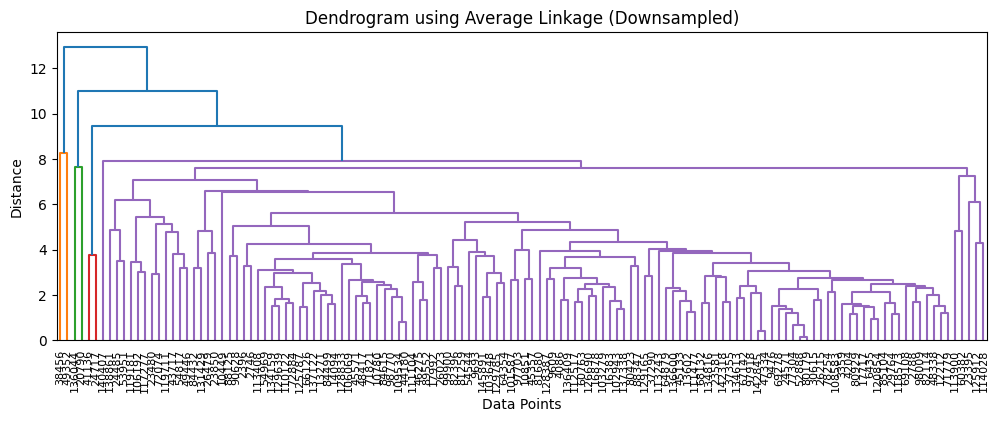

Number of Clusters using Average Linkage (Downsampled): 19
Silhouette Score using Average Linkage (Downsampled): 0.186


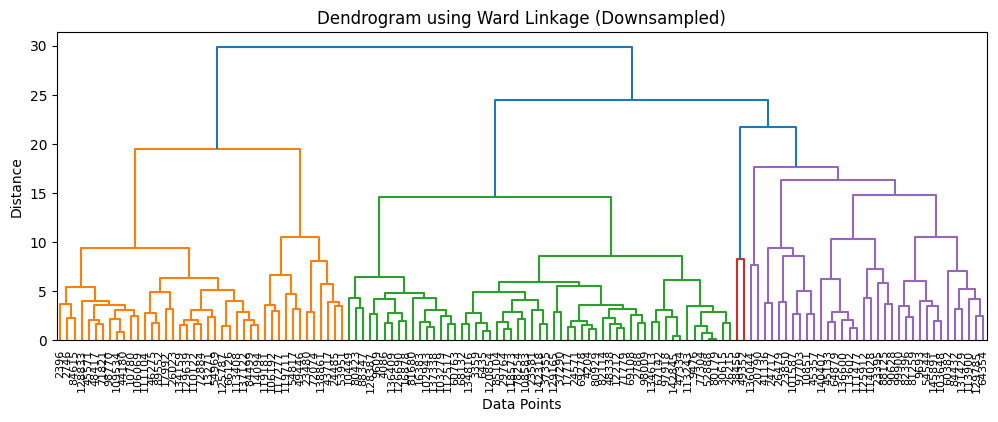

Number of Clusters using Ward Linkage (Downsampled): 34
Silhouette Score using Ward Linkage (Downsampled): 0.155


Silhouette Scores: {'single': 0.314, 'complete': 0.164, 'average': 0.186, 'ward': 0.155}


In [11]:
# Filter data for the state of California
california_data = incidents_dataset[incidents_dataset['state'] == 'CALIFORNIA'].copy()

# Drop rows with missing values
california_data = california_data.dropna()

# Select features for clustering
selected_features = california_data.select_dtypes(include=['number']).columns

# Downsample the dataset for a clearer visualization
sampled_data = california_data.sample(frac=0.05, random_state=42)

# Standardize features for the downsampled data
scaler = StandardScaler()
sampled_data_standardized = scaler.fit_transform(sampled_data[selected_features])

# Initialize an empty dictionary to store Silhouette Scores for each method
silhouette_scores = {}

# Choose different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']

clusters_hierarchical = []
# Compare different clustering results
for method in linkage_methods:
    # Perform hierarchical clustering on the downsampled data
    Z = linkage(sampled_data_standardized, method=method)

    # Visualize the dendrogram
    plt.figure(figsize=(12, 4))
    dendrogram_data = dendrogram(Z, labels=sampled_data.index, leaf_rotation=90, leaf_font_size=8)
    plt.title(f'Dendrogram using {method.capitalize()} Linkage (Downsampled)')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.show()

    # Cut the dendrogram to obtain clusters
    clusters = fcluster(Z, t=5.0, criterion='distance')
    clusters_hierarchical.append({
                                    'linkage_method': method,
                                    'clusters': clusters,
                                    'dendrogram': Z
                                })
    num_clusters = len(np.unique(clusters))
    print(f"Number of Clusters using {method.capitalize()} Linkage (Downsampled): {num_clusters}")

    # Calculate Silhouette Score
    silhouette = round(silhouette_score(sampled_data_standardized, clusters), 3)
    
    # Store Silhouette Score in the dictionary
    silhouette_scores[method] = silhouette

    # Print the Silhouette Score
    print(f"Silhouette Score using {method.capitalize()} Linkage (Downsampled): {silhouette}")

# Print the dictionary of Silhouette Scores
print("\n\nSilhouette Scores:", silhouette_scores)


## Evaluation and comparison of the used clustering approaches

To perform a final evaluation and comparison of the clustering approaches (k-means, density-based clustering, and hierarchical clustering), we will consider several factors:

- **Silhouette Score**: Evaluate the silhouette score for each method to assess the quality of the clusters. A higher silhouette score indicates better-defined clusters.
- **Interpretability**: Consider the interpretability of the clusters obtained from each method. Are the clusters meaningful and aligned with the characteristics of the data?
- **Number of Clusters**: Compare the number of clusters obtained by each method. Consider whether the number of clusters makes sense in the context of our analysis.
- **Computational Complexity**: Evaluate the computational complexity of each method, especially if dealing with large datasets. Some methods may be more computationally expensive than others.
- **Visualization**: Visualize the clusters obtained from each method using scatter plots, dendrograms, or other relevant visualizations. This can provide insights into the structure of the clusters.

In [12]:
# K-means clustering results Silhouette Score
silhouette_kmeans = round(silhouette_score(data_for_clustering_standardized, clusters_kmeans), 3)
print(f"Silhouette Score (K-means): {silhouette_kmeans}")

# Density-Based Clustering (DBSCAN) results Silhouette Score
silhouette_dbscan = round(silhouette_score(california_data_standardized, clusters_dbscan), 3)
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")

# Hierarchical Clustering results Silhouette Score
for cluster in clusters_hierarchical:
    silhouette_hierarchical = silhouette_score(sampled_data_standardized, cluster['clusters'])
    print('Silhouette Score (Hierarchical - ' + str(cluster['linkage_method']) + '): ' + str(round(silhouette_hierarchical, 3)))

Silhouette Score (K-means): 0.16
Silhouette Score (DBSCAN): 0.654
Silhouette Score (Hierarchical - single): 0.314
Silhouette Score (Hierarchical - complete): 0.164
Silhouette Score (Hierarchical - average): 0.186
Silhouette Score (Hierarchical - ward): 0.155


Regarding to the Silhouette score, there is a clear winner. Density based clustering has a high score, compared with the rest of approaches.

<center>

| Clustering Method          | Silhouette Score |
|----------------------------|:----------------:|
| K-means                    | 0.16             |
| Density-Based              | 0.654            |
| (Hierarchical - Single)    | 0.314            |
| (Hierarchical - Complete)  | 0.164            |
| (Hierarchical - Average)   | 0.186            |
| (Hierarchical - Ward)      | 0.155            |

</center>

### K-means Clustering

#### Interpretability 
K-means assigns each data point to the cluster whose centroid is nearest. Interpretability is relatively high as you can analyze the centroid of each cluster to understand the "average" behavior of the points in that cluster.

#### Visualization

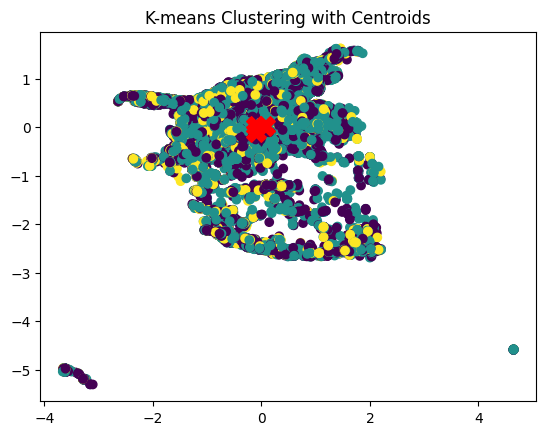

In [13]:
plt.scatter(data_for_clustering_standardized[:, 0], data_for_clustering_standardized[:, 1], c=clusters_kmeans, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, c='red')
plt.title('K-means Clustering with Centroids')
plt.show()

###  Density-Based Clustering (DBSCAN)

#### Interpretability

DBSCAN identifies clusters based on density-connected regions. The clusters are not required to be of a specific shape, making it suitable for complex data distributions. Interpretability may vary based on the density of the data.

#### Visualization

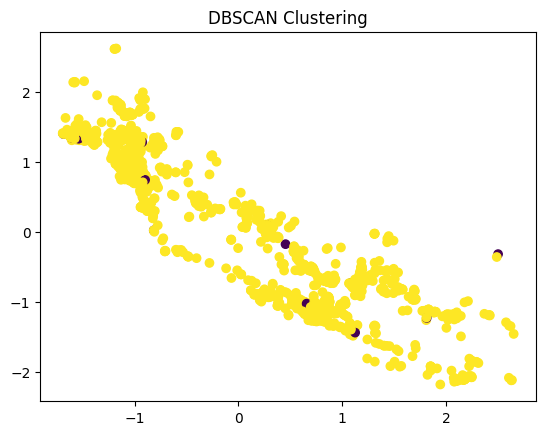

In [14]:
plt.scatter(california_data_standardized[:, 0], california_data_standardized[:, 1], c=clusters_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.show()

### Hierarchical Clustering

#### Interpretability
Hierarchical clustering organizes data into a tree structure (dendrogram). Interpretability comes from observing the branches and the resulting clusters at different levels of the hierarchy.

#### Visualization

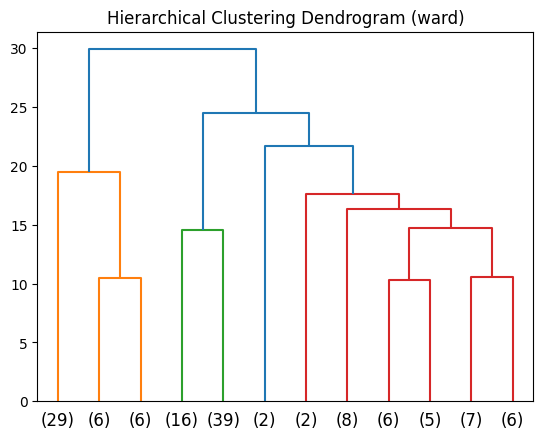

In [15]:
dendrogram(cluster['dendrogram'], labels=range(len(sampled_data_standardized)), truncate_mode='lastp', p=12)
plt.title(f'Hierarchical Clustering Dendrogram ({cluster["linkage_method"]})')
plt.show()

#### Compare number of clusters

In [16]:
# Number of clusters obtained by each method
num_clusters_kmeans = len(set(clusters_kmeans))
num_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)  # Exclude noise points for DBSCAN
num_clusters_hierarchical = max([max(cluster['clusters']) for cluster in clusters_hierarchical])

# Print the results
print(f"Number of Clusters (K-means): {num_clusters_kmeans}")
print(f"Number of Clusters (DBSCAN): {num_clusters_dbscan}")
print(f"Number of Clusters (Hierarchical): {num_clusters_hierarchical}")

Number of Clusters (K-means): 3
Number of Clusters (DBSCAN): 1
Number of Clusters (Hierarchical): 34
